In [7]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [8]:
import numpy as np
import random
import math
import time
import os
import matplotlib.cm as cm
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import matplotlib.pyplot as plt
%matplotlib inline

from tqdm.notebook import tqdm
from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

# 1. load data

In [9]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index).astype(int) # Convert the resulting indices to integers






def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


# leave-one-out evaluation: one battery is sampled randomly; the remainder are used for training.
def get_train_test(data_dict, name, window_size=8):
    data_sequence=data_dict[name]['capacity']
    # Check if enough data is available for the window size
    if len(data_sequence) <= window_size + 1:
        raise ValueError(f"Not enough data for battery {name} with window size {window_size}. "
                         f"Available data points: {len(data_sequence)}, required: {window_size + 2}")
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]

    return train_x, train_y, list(train_data), list(test_data)

def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re if abs(true_re - pred_re)/true_re<=1 else 1


def evaluation(y_test, y_predict):
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return rmse


def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

## 1.1 Extract raw data

In [10]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = '/content/drive/MyDrive/5 TRANSFORMER/RUL/datasets/CALCE'
Battery = {}
for name in Battery_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheetname=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]

    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheetname=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)

    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result


Load Dataset CS2_35 ...
Load Dataset CS2_36 ...
Load Dataset CS2_37 ...
Load Dataset CS2_38 ...


## or 1.1 load the extracted data

**note: If the above loading fails, please load the .npy file.**

In [12]:
Battery_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('/content/drive/MyDrive/5 TRANSFORMER/RUL/datasets/CALCE/CALCE.npy', allow_pickle=True)
Battery = Battery.item()

## 1.2 plot figures for capacity degradation

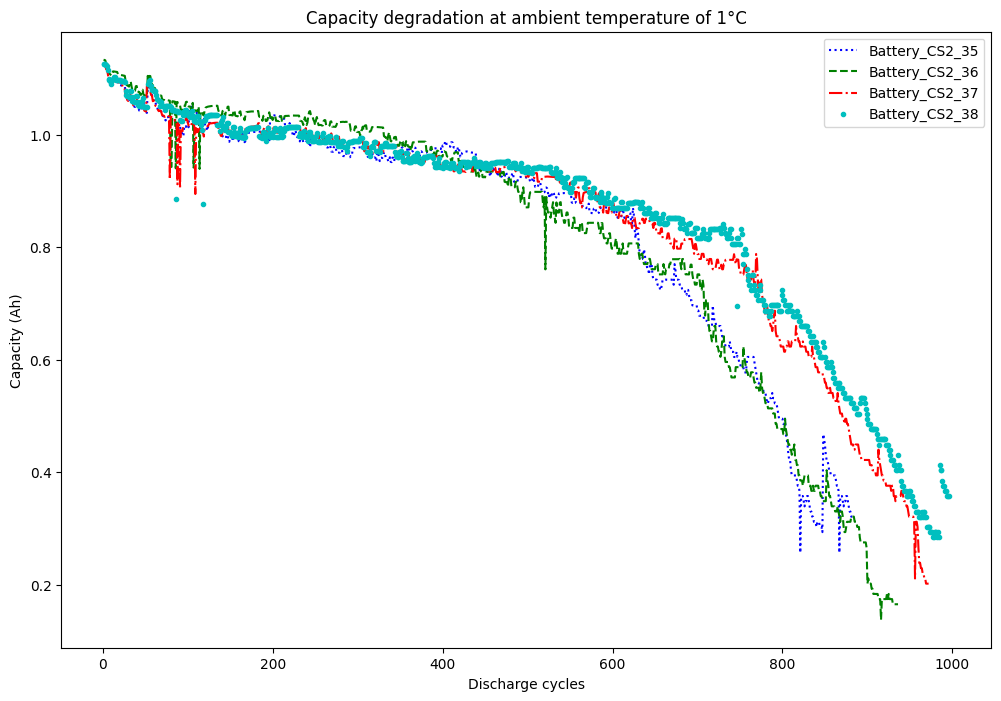

In [13]:
# Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battery_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

# 2. build model and train

## 2.1 build model

In [14]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.01):
        '''
        Args:
            input_size: the feature size of input data (required).
            hidden_dim: the hidden size of AutoEncoder (required).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(Autoencoder, self).__init__()
        self.noise_level = noise_level
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_size)

    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1

    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x

    def decoder(self, x):
        h2 = self.fc2(x)
        return h2

    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode


class PositionalEncoding(nn.Module):
    def __init__(self, feature_len, feature_size, dropout=0.0):
        '''
        Args:
            feature_len: the feature length of input data (required).
            feature_size: the feature size of input data (required).
            dropout: the dropout rate (optional).
        '''
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(feature_len, feature_size)
        position = torch.arange(0, feature_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, feature_size, 2).float() * (-math.log(10000.0) / feature_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe

        return x


class Net(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=32, feature_num=1, num_layers=1, nhead=1, dropout=0.0, noise_level=0.01):
        '''
        Args:
            feature_size: the feature size of input data (required).
            hidden_dim: the hidden size of Transformer block (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(Net, self).__init__()
        self.auto_hidden = int(feature_size / 2)
        input_size = self.auto_hidden

        if feature_num == 1:
            # Transformer treated as an Encoder when modeling for a sigle feature like only capacity data
            self.pos = PositionalEncoding(feature_len=feature_num, feature_size=input_size)
            encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        elif feature_num > 1:
            # Transformer treated as a sequence model when modeling for multi-features like capacity, voltage, and current data
            self.pos = PositionalEncoding(feature_len=input_size, feature_size=feature_num)
            encoder_layers = nn.TransformerEncoderLayer(d_model=feature_num, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.linear = nn.Linear(feature_num*self.auto_hidden, 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)

    def forward(self, x):
        batch_size, feature_num, feature_size  = x.shape
        out, decode = self.autoencoder(x)
        if feature_num > 1:
            out = out.reshape(batch_size, -1, feature_num)
        out = self.pos(out)
        out = self.cell(out)              # sigle feature: (batch_size, feature_num, auto_hidden) or multi-features: (batch_size, auto_hidden, feature_num)
        out = out.reshape(batch_size, -1) # (batch_size, feature_num*auto_hidden)
        out = self.linear(out)            # out shape: (batch_size, 1)

        return out, decode

In [15]:
def train(lr=0.01, feature_size=8, feature_num=1, hidden_dim=32, num_layers=1, nhead=1, dropout=0.0, epochs=1000,
          weight_decay=0.0, seed=0, alpha=0.0, noise_level=0.0, metric='re', device='cpu'):
    '''
        Args:
            lr: learning rate for training (required).
            feature_size: the feature size of input data (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            hidden_dim: the hidden size of Transformer block (required).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            epochs:
            weight_decay:
            seed: (optional).
            alpha: (optional).
            noise_level: the noise level added in Autoencoder (optional).
            metric: (optional).
            device: (optional).
        '''
    score_list, fixed_result_list, moving_result_list = [], [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, feature_size)
        test_sequence = train_data + test_data
        # print('sample size: {}'.format(len(train_x)))

        model = Net(feature_size=feature_size, hidden_dim=hidden_dim, feature_num=K, num_layers=num_layers,
                    nhead=nhead, dropout=dropout, noise_level=noise_level)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_fixed_slice, y_moving_slice = [0], [], []
        rmse, re = 1, 1
        score_, score = [1],[1]
        for epoch in range(epochs):
            x = np.reshape(train_x/Rated_Capacity,(-1, feature_num, feature_size)).astype(np.float32)
            y = np.reshape(train_y/Rated_Capacity,(-1,1)).astype(np.float32)

            x, y = torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)
            x = x.repeat(1, K, 1)
            output, decode = model(x)
            output = output.reshape(-1, 1)
            loss = criterion(output, y) + alpha * criterion(decode, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1)%10 == 0:
                test_x = train_data.copy()
                fixed_point_list, moving_point_list = [], []
                t = 0
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, feature_num, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)      # The test values are added to the original sequence to continue to predict the next point
                    fixed_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence

                    x = np.reshape(np.array(test_sequence[t:t+feature_size])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    moving_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence
                    t += 1

                y_fixed_slice.append(fixed_point_list)             # Save all the predicted values
                y_moving_slice.append(moving_point_list)

                loss_list.append(loss)
                rmse = evaluation(y_test=test_data, y_predict=y_fixed_slice[-1])
                re = relative_error(y_test=test_data, y_predict=y_fixed_slice[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))

            if metric == 're':
                score = [re]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()

        score_list.append(score_)
        fixed_result_list.append(train_data.copy() + y_fixed_slice[-1])
        moving_result_list.append(train_data.copy() + y_moving_slice[-1])

    return score_list, fixed_result_list, moving_result_list

In [16]:
Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
hidden_dim = 16
num_layers = 3
lr = 0.001
weight_decay = 0.0
noise_level = 0.0
alpha = 0.1
metric = 're'
seed = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
K = 16

SCORE = []
for seed in tqdm(range(5)):
    print('seed:{}'.format(seed))
    score_list, _, _ = train(lr=lr, feature_size=feature_size, feature_num=feature_num, hidden_dim=hidden_dim, num_layers=num_layers,
                             nhead=nhead, weight_decay=weight_decay, epochs=epochs, seed=seed, dropout=dropout, alpha=alpha,
                             noise_level=noise_level, metric=metric, device=device)
    print(np.array(score_list))
    print(metric + 'for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

  0%|          | 0/5 [00:00<?, ?it/s]

seed:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.00348432]
 [0.03799655]
 [0.20923077]
 [0.10998553]]
refor this seed: 0.0902
------------------------------------------------------------------
seed:1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.00348432]
 [0.00345423]
 [0.19230769]
 [0.21273517]]
refor this seed: 0.1030
------------------------------------------------------------------
seed:2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.03484321]
 [0.01208981]
 [0.12307692]
 [0.08393632]]
refor this seed: 0.0635
------------------------------------------------------------------
seed:3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.04703833]
 [0.00518135]
 [0.24153846]
 [0.07814761]]
refor this seed: 0.0930
------------------------------------------------------------------
seed:4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.2369338 ]
 [0.08635579]
 [0.12153846]
 [0.10130246]]
refor this seed: 0.1365
------------------------------------------------------------------
re mean: 0.0972


In [17]:
Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
hidden_dim = 16
num_layers = 3
lr = 0.001
weight_decay = 0.0
noise_level = 0.0
alpha = 0.1
metric = 're'
seed = 1

K = 16

SCORE = []
print('seed:{}'.format(seed))
score_list, fixed_result_list, moving_result_list = train(lr=lr, feature_size=feature_size, feature_num=feature_num,
                                                          hidden_dim=hidden_dim, num_layers=num_layers,  nhead=nhead,
                                                          weight_decay=weight_decay, epochs=epochs, seed=seed, dropout=dropout,
                                                          alpha=alpha, noise_level=noise_level, metric=metric, device=device)
print(np.array(score_list))
for s in score_list:
    SCORE.append(s)
print('------------------------------------------------------------------')
print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

seed:1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.00348432]
 [0.00345423]
 [0.19230769]
 [0.21273517]]
------------------------------------------------------------------
re mean: 0.1030


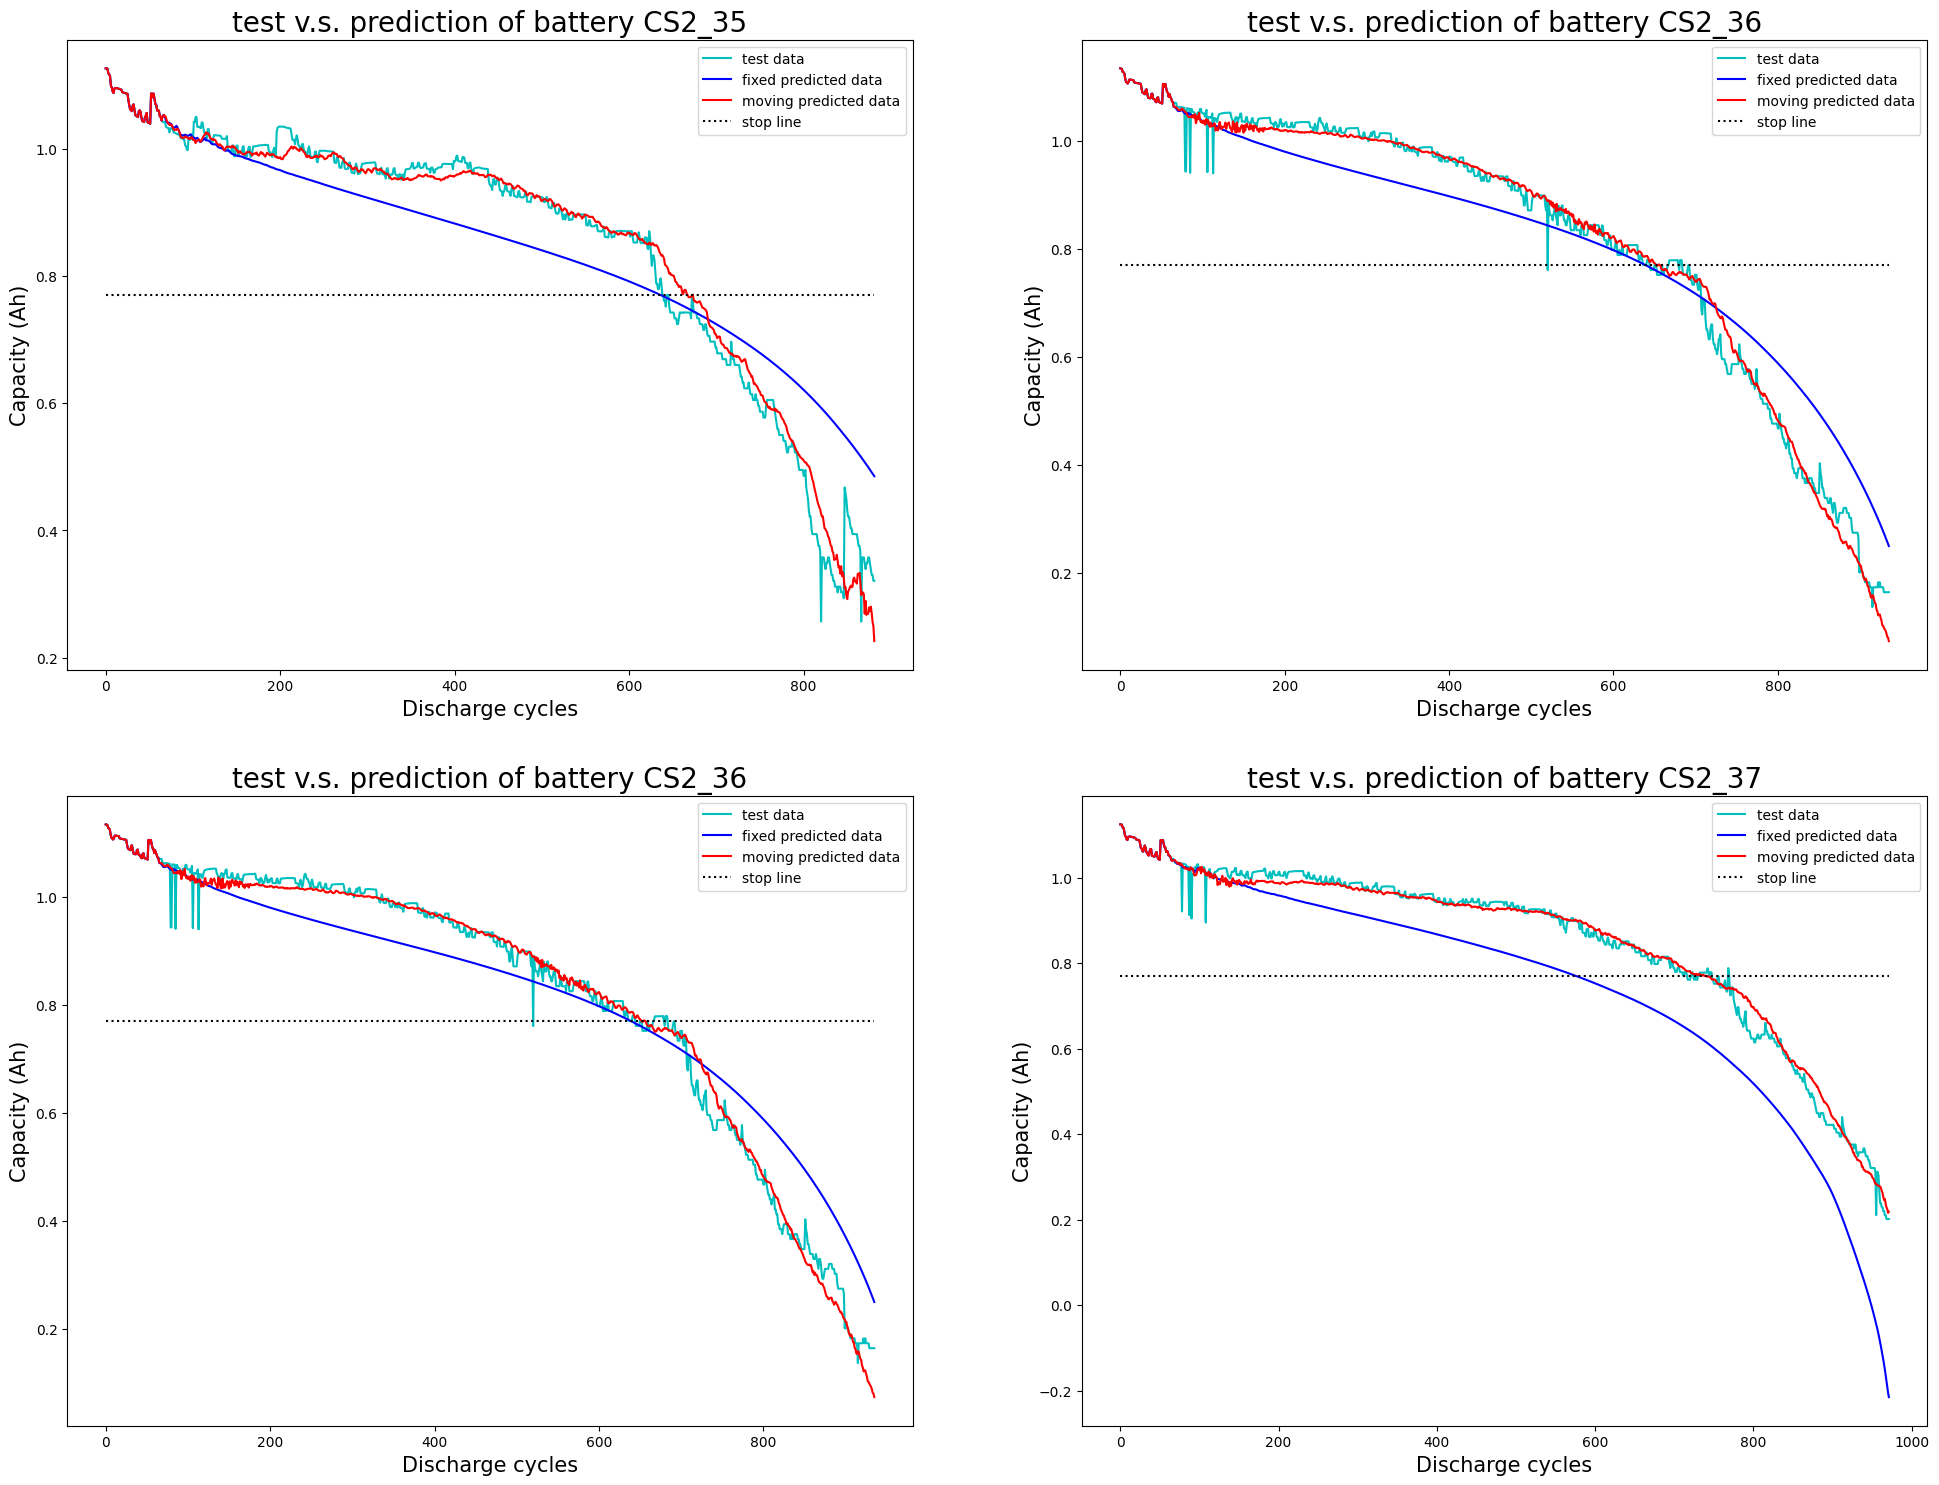

In [18]:
fig,ax = plt.subplots(2, 2, figsize=(24, 18))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = Battery[battery_name]['capacity']
        fixed_predict_data = fixed_result_list[t]
        moving_predict_data = moving_result_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        ax[i][j].plot(x, fixed_predict_data, 'b', label='fixed predicted data')
        ax[i][j].plot(x, moving_predict_data, 'r', label='moving predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='stop line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test v.s. prediction of battery ' + battery_name, fontsize=20)
plt.show()

In [ ]:
Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
alpha = 0.1

weight_decay = 0.0
noise_level = 0.0
metric = 're'

states = {}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for K in tqdm([4, 8, 16, 32], position=0):
    for lr in tqdm([0.0001, 0.001, 0.01], position=1):
        for num_layers in tqdm([1, 2, 3], position=2):
            for hidden_dim in [8, 16, 32, 64]:
                show_str = 'K={}, lr={}, num_layers={}, hidden_dim={}'.format(K, lr, num_layers, hidden_dim)
                print(show_str)
                SCORE = []
                for seed in range(5):
                    print('seed:{}'.format(seed))
                    score_list, _, _ = train(lr=lr, feature_size=feature_size, feature_num=feature_num, hidden_dim=hidden_dim,
                                             num_layers=num_layers, nhead=nhead, weight_decay=weight_decay, epochs=epochs, seed=seed,
                                             dropout=dropout, alpha=alpha, noise_level=noise_level, metric=metric, device=device)
                    print(np.array(score_list))
                    print(metric + ': {:<6.4f}'.format(np.mean(np.array(score_list))))
                    print('------------------------------------------------------------------')
                    for s in score_list:
                        SCORE.append(s)

                print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
                states[show_str] = np.mean(np.array(SCORE))
                print('===================================================================')

min_key = min(states, key = states.get)
print('optimal parameters: {}, result: {}'.format(min_key, states[min_key]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

K=4, lr=0.0001, num_layers=1, hidden_dim=8
seed:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.33449477]
 [1.        ]
 [0.22769231]
 [1.        ]]
re: 0.6405
------------------------------------------------------------------
seed:1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.09581882]
 [0.06217617]
 [0.54      ]
 [1.        ]]
re: 0.4245
------------------------------------------------------------------
seed:2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.03832753]
 [0.15716753]
 [0.22      ]
 [0.16208394]]
re: 0.1444
------------------------------------------------------------------
seed:3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.10278746]
 [1.        ]
 [0.25692308]
 [0.28219971]]
re: 0.4105
------------------------------------------------------------------
seed:4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[1.        ]
 [1.        ]
 [1.        ]
 [0.76410999]]
re: 0.9410
------------------------------------------------------------------
re mean: 0.5122
K=4, lr=0.0001, num_layers=1, hidden_dim=16
seed:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[1.        ]
 [1.        ]
 [0.53384615]
 [1.        ]]
re: 0.8835
------------------------------------------------------------------
seed:1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[1.        ]
 [0.63385147]
 [1.        ]
 [0.18523878]]
re: 0.7048
------------------------------------------------------------------
seed:2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[1.        ]
 [0.25215889]
 [0.54615385]
 [1.        ]]
re: 0.6996
------------------------------------------------------------------
seed:3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[1.        ]
 [0.97927461]
 [1.        ]
 [1.        ]]
re: 0.9948
------------------------------------------------------------------
seed:4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.02439024]
 [0.84455959]
 [0.22153846]
 [0.3024602 ]]
re: 0.3482
------------------------------------------------------------------
re mean: 0.7262
K=4, lr=0.0001, num_layers=1, hidden_dim=32
seed:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.04006969]
 [1.        ]
 [0.16615385]
 [1.        ]]
re: 0.5516
------------------------------------------------------------------
seed:1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[0.09756098]
 [1.        ]
 [0.48615385]
 [0.16208394]]
re: 0.4364
------------------------------------------------------------------
seed:2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[1.        ]
 [1.        ]
 [0.21076923]
 [1.        ]]
re: 0.8027
------------------------------------------------------------------
seed:3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[1.        ]
 [0.4283247 ]
 [0.1       ]
 [0.16497829]]
re: 0.4233
------------------------------------------------------------------
seed:4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


[[1.        ]
 [1.        ]
 [0.02923077]
 [1.        ]]
re: 0.7573
------------------------------------------------------------------
re mean: 0.5943
K=4, lr=0.0001, num_layers=1, hidden_dim=64
seed:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(


In [7]:
import math
import torch
from torch import nn
import torch.nn.functional as F


class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.weight * (x - mean) / (std + self.eps) + self.bias


class Attention(nn.Module):
    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)
        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)



    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        x, attn = self.attention(
            query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(
            batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.activation(self.w_1(x)))


class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.layer_norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return self.layer_norm(x + self.dropout(sublayer(x)))


class TransformerBlock(nn.Module):
    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        super().__init__()
        self.attention = MultiHeadedAttention(
            h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(
            d_model=hidden, d_ff=feed_forward_hidden)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(
            x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)


class BERT4BMS(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        self.original_len = args.window_size
        self.latent_len = int(self.original_len / 2)
        self.dropout_rate = args.drop_out

        self.hidden = 256
        self.heads = 2
        self.n_layers = 2
        self.output_size = args.output_size
        self.conv = nn.Conv1d(in_channels=1, out_channels=self.hidden,
                              kernel_size=5, stride=1, padding=2, padding_mode='zeros')  # Change padding_mode to 'zeros'


        #self.conv = nn.Conv1d(in_channels=1, out_channels=self.hidden,
                               #kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        self.pool = nn.LPPool1d(norm_type=2, kernel_size=2, stride=2)

        self.position = PositionalEmbedding(
            max_len=self.latent_len, d_model=self.hidden)
        self.layer_norm = LayerNorm(self.hidden)
        self.dropout = nn.Dropout(p=self.dropout_rate)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(
            self.hidden, self.heads, self.hidden * 4, self.dropout_rate) for _ in range(self.n_layers)])

        self.deconv = nn.ConvTranspose1d(
            in_channels=self.hidden, out_channels=self.hidden, kernel_size=4, stride=2, padding=1)
        self.linear1 = nn.Linear(self.hidden, 128)
        self.linear2 = nn.Linear(128, self.output_size)

        self.truncated_normal_init()

    def truncated_normal_init(self, mean=0, std=0.02, lower=-0.04, upper=0.04):
        params = list(self.named_parameters())
        for n, p in params:
            if 'layer_norm' in n:
                continue
            else:
                with torch.no_grad():
                    l = (1. + math.erf(((lower - mean) / std) / math.sqrt(2.))) / 2.
                    u = (1. + math.erf(((upper - mean) / std) / math.sqrt(2.))) / 2.
                    p.uniform_(2 * l - 1, 2 * u - 1)
                    p.erfinv_()
                    p.mul_(std * math.sqrt(2.))
                    p.add_(mean)

    def forward(self, sequence):
        x_token = self.pool(self.conv(sequence.unsqueeze(1))).permute(0, 2, 1)
        #x_token = self.pool(self.conv(sequence.unsqueeze(1))).permute(0, 2, 1)
        embedding = x_token + self.position(sequence)
        x = self.dropout(self.layer_norm(embedding))

        mask = None
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        x = self.deconv(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x

Existing code

In [8]:
class Autoencoder(nn.Module):
    def __init__(self, input_size=16, hidden_dim=8, noise_level=0.01):
        '''
        Args:
            input_size: the feature size of input data (required).
            hidden_dim: the hidden size of AutoEncoder (required).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(Autoencoder, self).__init__()
        self.noise_level = noise_level
        self.fc1 = nn.Linear(input_size, hidden_dim)
        self.fc2 = nn.Linear(hidden_dim, input_size)

    def encoder(self, x):
        x = self.fc1(x)
        h1 = F.relu(x)
        return h1

    def mask(self, x):
        corrupted_x = x + self.noise_level * torch.randn_like(x)
        return corrupted_x

    def decoder(self, x):
        h2 = self.fc2(x)
        return h2

    def forward(self, x):
        out = self.mask(x)
        encode = self.encoder(out)
        decode = self.decoder(encode)
        return encode, decode


class PositionalEncoding(nn.Module):
    def __init__(self, feature_len, feature_size, dropout=0.0):
        '''
        Args:
            feature_len: the feature length of input data (required).
            feature_size: the feature size of input data (required).
            dropout: the dropout rate (optional).
        '''
        super(PositionalEncoding, self).__init__()

        pe = torch.zeros(feature_len, feature_size)
        position = torch.arange(0, feature_len, dtype=torch.float).unsqueeze(1)

        div_term = torch.exp(torch.arange(0, feature_size, 2).float() * (-math.log(10000.0) / feature_size))

        pe[:, 0::2] = torch.sin(position * div_term)
        pe[:, 1::2] = torch.cos(position * div_term)

        pe = pe.unsqueeze(0)

        self.register_buffer('pe', pe)

    def forward(self, x):
        x = x + self.pe

        return x


class Net(nn.Module):
    def __init__(self, feature_size=16, hidden_dim=32, feature_num=1, num_layers=1, nhead=1, dropout=0.0, noise_level=0.01):
        '''
        Args:
            feature_size: the feature size of input data (required).
            hidden_dim: the hidden size of Transformer block (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            noise_level: the noise level added in Autoencoder (optional).
        '''
        super(Net, self).__init__()
        self.auto_hidden = int(feature_size / 2)
        input_size = self.auto_hidden

        if feature_num == 1:
            # Transformer treated as an Encoder when modeling for a sigle feature like only capacity data
            self.pos = PositionalEncoding(feature_len=feature_num, feature_size=input_size)
            encoder_layers = nn.TransformerEncoderLayer(d_model=input_size, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        elif feature_num > 1:
            # Transformer treated as a sequence model when modeling for multi-features like capacity, voltage, and current data
            self.pos = PositionalEncoding(feature_len=input_size, feature_size=feature_num)
            encoder_layers = nn.TransformerEncoderLayer(d_model=feature_num, nhead=nhead, dim_feedforward=hidden_dim, dropout=dropout, batch_first=True)
        self.cell = nn.TransformerEncoder(encoder_layers, num_layers=num_layers)

        self.linear = nn.Linear(feature_num*self.auto_hidden, 1)
        self.autoencoder = Autoencoder(input_size=feature_size, hidden_dim=self.auto_hidden, noise_level=noise_level)

    def forward(self, x):
        batch_size, feature_num, feature_size  = x.shape
        out, decode = self.autoencoder(x)
        if feature_num > 1:
            out = out.reshape(batch_size, -1, feature_num)
        out = self.pos(out)
        out = self.cell(out)              # sigle feature: (batch_size, feature_num, auto_hidden) or multi-features: (batch_size, auto_hidden, feature_num)
        out = out.reshape(batch_size, -1) # (batch_size, feature_num*auto_hidden)
        out = self.linear(out)            # out shape: (batch_size, 1)

        return out, decode

## 2.2 train for model

In [12]:
import math
import torch
from torch import nn
import torch.nn.functional as F
from tqdm import tqdm # Import tqdm for the progress bar


class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


# ... (Rest of the model definition: PositionalEmbedding, LayerNorm, Attention, MultiHeadedAttention, PositionwiseFeedForward, SublayerConnection, TransformerBlock, BERT4BMS) ...


class Config: # Define the Config class before it is used
    def __init__(self, feature_size, hidden_dim, num_layers, nhead, dropout, output_size, window_size, drop_out):
        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.nhead = nhead
        self.dropout = dropout
        self.output_size = output_size
        self.window_size = window_size
        self.drop_out = drop_out


def train(lr=0.01, feature_size=8, feature_num=1, hidden_dim=32, num_layers=1, nhead=1, dropout=0.0, epochs=1000,
          weight_decay=0.0, seed=0, alpha=0.0, noise_level=0.0, metric='re', device='cpu'):
    '''
        Args:
            lr: learning rate for training (required).
            feature_size: the feature size of input data (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            hidden_dim: the hidden size of Transformer block (required).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            epochs:
            weight_decay:
            seed: (optional).
            alpha: (optional).
            noise_level: the noise level added in Autoencoder (optional).
            metric: (optional).
            device: (optional).
        '''
    score_list, fixed_result_list, moving_result_list = [], [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, feature_size)
        test_sequence = train_data + test_data
        # print('sample size: {}'.format(len(train_x)))

        # Create a Config object to store the model parameters
        args = Config(feature_size=feature_size, hidden_dim=hidden_dim, num_layers=num_layers,
                      nhead=nhead, dropout=dropout, output_size=K, window_size=feature_size, drop_out=dropout)

        model = BERT4BMS(args) # Pass the Config object to the model constructor
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_fixed_slice, y_moving_slice = [0], [], []
        rmse, re = 1, 1
        score_, score = [1],[1]
        for epoch in range(epochs):
            x = np.reshape(train_x/Rated_Capacity,(-1, feature_num, feature_size)).astype(np.float32)
            y = np.reshape(train_y/Rated_Capacity,(-1,1)).astype(np.float32)

            x, y = torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)
            # Remove or modify the repeat operation:
            # x = x.repeat(1, K, 1)
            # Instead, you might need to reshape x to (batch_size, 1, feature_size)
            x = x.reshape(-1, 1, feature_size) # Reshape to 3D for conv1d

            output = model(x) # BERT4BMS model returns a single output
            output = output.reshape(-1, 1)
            loss = criterion(output, y) # Removed alpha and decode as they are not used in BERT4BMS
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1)%10 == 0:
                test_x = train_data.copy()
                fixed_point_list, moving_point_list = [], []
                t = 0
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, feature_num, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)      # The test values are added to the original sequence to continue to predict the next point
                    fixed_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence

                    x = np.reshape(np.array(test_sequence[t:t+feature_size])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    moving_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence
                    t += 1

                y_fixed_slice.append(fixed_point_list)             # Save all the predicted values
                y_moving_slice.append(moving_point_list)

                loss_list.append(loss)
                rmse = evaluation(y_test=test_data, y_predict=y_fixed_slice[-1])
                re = relative_error(y_test=test_data, y_predict=y_fixed_slice[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))

            if metric == 're':
                score = [re]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()

        score_list.append(score_)
        fixed_result_list.append(train_data.copy() + y_fixed_slice[-1])
        moving_result_list.append(train_data.copy() + y_moving_slice[-1])

    return score_list, fixed_result_list, moving_result_list

            # ... (rest of the training code)

In [17]:
print(train_x.shape)

NameError: name 'train_x' is not defined

In [9]:
def train(lr=0.01, feature_size=8, feature_num=1, hidden_dim=32, num_layers=1, nhead=1, dropout=0.0, epochs=1000,
          weight_decay=0.0, seed=0, alpha=0.0, noise_level=0.0, metric='re', device='cpu'):
    '''
        Args:
            lr: learning rate for training (required).
            feature_size: the feature size of input data (required).
            feature_num: the number of features, such as capacity, voltage, and current; set 1 for only sigle feature (optional).
            hidden_dim: the hidden size of Transformer block (required).
            num_layers: the number of layers of Transformer block (optional).
            nhead: the number of heads of multi-attention in Transformer block (optional).
            dropout: the dropout rate of Transformer block (optional).
            epochs:
            weight_decay:
            seed: (optional).
            alpha: (optional).
            noise_level: the noise level added in Autoencoder (optional).
            metric: (optional).
            device: (optional).
        '''
    score_list, fixed_result_list, moving_result_list = [], [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, feature_size)
        test_sequence = train_data + test_data
        # print('sample size: {}'.format(len(train_x)))

        model = BERT4BMS(feature_size=feature_size, hidden_dim=hidden_dim, feature_num=K, num_layers=num_layers,
                    nhead=nhead, dropout=dropout, noise_level=noise_level)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_fixed_slice, y_moving_slice = [0], [], []
        rmse, re = 1, 1
        score_, score = [1],[1]
        for epoch in range(epochs):
            x = np.reshape(train_x/Rated_Capacity,(-1, feature_num, feature_size)).astype(np.float32)
            y = np.reshape(train_y/Rated_Capacity,(-1,1)).astype(np.float32)

            x, y = torch.from_numpy(x).to(device), torch.from_numpy(y).to(device)
            x = x.repeat(1, K, 1)
            output, decode = model(x)
            output = output.reshape(-1, 1)
            loss = criterion(output, y) + alpha * criterion(decode, x)
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            if (epoch + 1)%10 == 0:
                test_x = train_data.copy()
                fixed_point_list, moving_point_list = [], []
                t = 0
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity,(-1, feature_num, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)      # The test values are added to the original sequence to continue to predict the next point
                    fixed_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence

                    x = np.reshape(np.array(test_sequence[t:t+feature_size])/Rated_Capacity,(-1, 1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    x = x.repeat(1, K, 1)
                    pred, _ = model(x)
                    next_point = pred.data.cpu().numpy()[0,0] * Rated_Capacity
                    moving_point_list.append(next_point) # Saves the predicted value of the last point in the output sequence
                    t += 1

                y_fixed_slice.append(fixed_point_list)             # Save all the predicted values
                y_moving_slice.append(moving_point_list)

                loss_list.append(loss)
                rmse = evaluation(y_test=test_data, y_predict=y_fixed_slice[-1])
                re = relative_error(y_test=test_data, y_predict=y_fixed_slice[-1], threshold=Rated_Capacity*0.7)
                #print('epoch:{:<2d} | loss:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, rmse, re))

            if metric == 're':
                score = [re]
            elif metric == 'rmse':
                score = [rmse]
            else:
                score = [re, rmse]
            if (loss < 1e-3) and (score_[0] < score[0]):
                break
            score_ = score.copy()

        score_list.append(score_)
        fixed_result_list.append(train_data.copy() + y_fixed_slice[-1])
        moving_result_list.append(train_data.copy() + y_moving_slice[-1])

    return score_list, fixed_result_list, moving_result_list

In [12]:
!pip install inspect # Install the inspect module
import inspect # Import the inspect module

# Check if BERT4BMS is defined and inspect its constructor
if 'BERT4BMS' in globals():
    print(inspect.getsource(BERT4BMS.__init__))
else:
    print("BERT4BMS is not defined in the current scope.")

ERROR: Could not find a version that satisfies the requirement inspect (from versions: none)
ERROR: No matching distribution found for inspect
    def __init__(self, args):
        super().__init__()
        self.args = args

        self.original_len = args.window_size
        self.latent_len = int(self.original_len / 2)
        self.dropout_rate = args.drop_out

        self.hidden = 256
        self.heads = 2
        self.n_layers = 2
        self.output_size = args.output_size

        self.conv = nn.Conv1d(in_channels=1, out_channels=self.hidden,
                               kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        self.pool = nn.LPPool1d(norm_type=2, kernel_size=2, stride=2)

        self.position = PositionalEmbedding(
            max_len=self.latent_len, d_model=self.hidden)
        self.layer_norm = LayerNorm(self.hidden)
        self.dropout = nn.Dropout(p=self.dropout_rate)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(
   

In [10]:
import inspect  # Import the inspect module

# Check if BERT4BMS is defined and inspect its constructor
if 'BERT4BMS' in globals():
    try:
        print(inspect.getsource(BERT4BMS.__init__))
    except TypeError as e:
        print(f"Could not retrieve source code: {e}")
else:
    print("BERT4BMS is not defined in the current scope.")


    def __init__(self, args):
        super().__init__()
        self.args = args

        self.original_len = args.window_size
        self.latent_len = int(self.original_len / 2)
        self.dropout_rate = args.drop_out

        self.hidden = 256
        self.heads = 2
        self.n_layers = 2
        self.output_size = args.output_size
        self.conv = nn.Conv1d(in_channels=1, out_channels=self.hidden,
                              kernel_size=5, stride=1, padding=2, padding_mode='zeros')  # Change padding_mode to 'zeros'


        #self.conv = nn.Conv1d(in_channels=1, out_channels=self.hidden,
                               #kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        self.pool = nn.LPPool1d(norm_type=2, kernel_size=2, stride=2)

        self.position = PositionalEmbedding(
            max_len=self.latent_len, d_model=self.hidden)
        self.layer_norm = LayerNorm(self.hidden)
        self.dropout = nn.Dropout(p=self.dropout_rate)

        self.tran

## 2.3 setting and training for overall performance

In [13]:
Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
hidden_dim = 16
num_layers = 3
lr = 0.001
weight_decay = 0.0
noise_level = 0.0
alpha = 0.1
metric = 're'
seed = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
K = 16

SCORE = []
for seed in tqdm(range(5)):
    print('seed:{}'.format(seed))
    score_list, _, _ = train(lr=lr, feature_size=feature_size, feature_num=feature_num, hidden_dim=hidden_dim, num_layers=num_layers,
                             nhead=nhead, weight_decay=weight_decay, epochs=epochs, seed=seed, dropout=dropout, alpha=alpha,
                             noise_level=noise_level, metric=metric, device=device)
    print(np.array(score_list))
    print(metric + 'for this seed: {:<6.4f}'.format(np.mean(np.array(score_list))))
    for s in score_list:
        SCORE.append(s)
    print('------------------------------------------------------------------')
print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

  0%|          | 0/5 [00:00<?, ?it/s]

seed:0


RuntimeError: Expected 2D (unbatched) or 3D (batched) input to conv1d, but got input of size: [2713, 1, 1, 64]

In [18]:
import math
import torch
from torch import nn
import torch.nn.functional as F


class GELU(nn.Module):
    def forward(self, x):
        return 0.5 * x * (1 + torch.tanh(math.sqrt(2 / math.pi) * (x + 0.044715 * torch.pow(x, 3))))


class PositionalEmbedding(nn.Module):
    def __init__(self, max_len, d_model):
        super().__init__()
        self.pe = nn.Embedding(max_len, d_model)

    def forward(self, x):
        batch_size = x.size(0)
        return self.pe.weight.unsqueeze(0).repeat(batch_size, 1, 1)


class LayerNorm(nn.Module):
    def __init__(self, features, eps=1e-6):
        super(LayerNorm, self).__init__()
        self.weight = nn.Parameter(torch.ones(features))
        self.bias = nn.Parameter(torch.zeros(features))
        self.eps = eps

    def forward(self, x):
        mean = x.mean(-1, keepdim=True)
        std = x.std(-1, keepdim=True)
        return self.weight * (x - mean) / (std + self.eps) + self.bias


class Attention(nn.Module):
    def forward(self, query, key, value, mask=None, dropout=None):
        scores = torch.matmul(query, key.transpose(-2, -1)) / math.sqrt(query.size(-1))
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)

        p_attn = F.softmax(scores, dim=-1)
        if dropout is not None:
            p_attn = dropout(p_attn)

        return torch.matmul(p_attn, value), p_attn


class MultiHeadedAttention(nn.Module):
    def __init__(self, h, d_model, dropout=0.1):
        super().__init__()
        assert d_model % h == 0

        self.d_k = d_model // h
        self.h = h

        self.linear_layers = nn.ModuleList([nn.Linear(d_model, d_model) for _ in range(3)])
        self.output_linear = nn.Linear(d_model, d_model)
        self.attention = Attention()

        self.dropout = nn.Dropout(p=dropout)

    def forward(self, query, key, value, mask=None):
        batch_size = query.size(0)

        query, key, value = [l(x).view(batch_size, -1, self.h, self.d_k).transpose(1, 2)
                             for l, x in zip(self.linear_layers, (query, key, value))]

        x, attn = self.attention(
            query, key, value, mask=mask, dropout=self.dropout)

        x = x.transpose(1, 2).contiguous().view(
            batch_size, -1, self.h * self.d_k)

        return self.output_linear(x)


class PositionwiseFeedForward(nn.Module):
    def __init__(self, d_model, d_ff):
        super(PositionwiseFeedForward, self).__init__()
        self.w_1 = nn.Linear(d_model, d_ff)
        self.w_2 = nn.Linear(d_ff, d_model)
        self.activation = GELU()

    def forward(self, x):
        return self.w_2(self.activation(self.w_1(x)))


class SublayerConnection(nn.Module):
    def __init__(self, size, dropout):
        super(SublayerConnection, self).__init__()
        self.layer_norm = LayerNorm(size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, sublayer):
        return self.layer_norm(x + self.dropout(sublayer(x)))


class TransformerBlock(nn.Module):
    def __init__(self, hidden, attn_heads, feed_forward_hidden, dropout):
        super().__init__()
        self.attention = MultiHeadedAttention(
            h=attn_heads, d_model=hidden, dropout=dropout)
        self.feed_forward = PositionwiseFeedForward(
            d_model=hidden, d_ff=feed_forward_hidden)
        self.input_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.output_sublayer = SublayerConnection(size=hidden, dropout=dropout)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x, mask):
        x = self.input_sublayer(
            x, lambda _x: self.attention.forward(_x, _x, _x, mask=mask))
        x = self.output_sublayer(x, self.feed_forward)
        return self.dropout(x)


class BERT4BMS(nn.Module):
    def __init__(self, args):
        super().__init__()
        self.args = args

        self.original_len = args.window_size
        self.latent_len = int(self.original_len / 2)
        self.dropout_rate = args.drop_out

        self.hidden = 256
        self.heads = 2
        self.n_layers = 2
        self.output_size = args.output_size

        self.conv = nn.Conv1d(in_channels=1, out_channels=self.hidden,
                              kernel_size=5, stride=1, padding=2, padding_mode='replicate')
        self.pool = nn.LPPool1d(norm_type=2, kernel_size=2, stride=2)

        self.position = PositionalEmbedding(
            max_len=self.latent_len, d_model=self.hidden)
        self.layer_norm = LayerNorm(self.hidden)
        self.dropout = nn.Dropout(p=self.dropout_rate)

        self.transformer_blocks = nn.ModuleList([TransformerBlock(
            self.hidden, self.heads, self.hidden * 4, self.dropout_rate) for _ in range(self.n_layers)])

        self.deconv = nn.ConvTranspose1d(
            in_channels=self.hidden, out_channels=self.hidden, kernel_size=4, stride=2, padding=1)
        self.linear1 = nn.Linear(self.hidden, 128)
        self.linear2 = nn.Linear(128, self.output_size)

        self.truncated_normal_init()

    def truncated_normal_init(self, mean=0, std=0.02, lower=-0.04, upper=0.04):
        params = list(self.named_parameters())
        for n, p in params:
            if 'layer_norm' in n:
                continue
            else:
                with torch.no_grad():
                    l = (1. + math.erf(((lower - mean) / std) / math.sqrt(2.))) / 2.
                    u = (1. + math.erf(((upper - mean) / std) / math.sqrt(2.))) / 2.
                    p.uniform_(2 * l - 1, 2 * u - 1)
                    p.erfinv_()
                    p.mul_(std * math.sqrt(2.))
                    p.add_(mean)

    def forward(self, sequence):
        x_token = self.pool(self.conv(sequence.unsqueeze(1))).permute(0, 2, 1)
        embedding = x_token + self.position(sequence)
        x = self.dropout(self.layer_norm(embedding))

        mask = None
        for transformer in self.transformer_blocks:
            x = transformer.forward(x, mask)

        x = self.deconv(x.permute(0, 2, 1)).permute(0, 2, 1)
        x = torch.tanh(self.linear1(x))
        x = self.linear2(x)
        return x


def train(lr=0.01, feature_size=8, feature_num=1, hidden_dim=32, num_layers=1, nhead=1, dropout=0.0, epochs=1000,
          weight_decay=0.0, seed=0, alpha=0.0, noise_level=0.0, metric='re', device='cpu'):
    '''
    Args:
        lr: learning rate for training (required).
        feature_size: the feature size of input data (required).
        feature_num: the number of features, such as capacity, voltage, and current; set 1 for only a single feature (optional).
        hidden_dim: the hidden size of Transformer block (required).
        num_layers: the number of layers of Transformer block (optional).
        nhead: the number of heads of multi-attention in Transformer block (optional).
        dropout: the dropout rate of Transformer block (optional).
        epochs: number of training epochs (required).
        weight_decay: weight decay for the optimizer (optional).
        seed: random seed for reproducibility (optional).
        alpha: weight for the reconstruction loss (optional).
        noise_level: the noise level added in Autoencoder (optional).
        metric: evaluation metric ('re' or 'rmse') (optional).
        device: the device to train on ('cpu' or 'cuda') (optional).
    '''
    score_list, fixed_result_list, moving_result_list = [], [], []
    setup_seed(seed)
    for i in range(4):
        name = Battery_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, feature_size)
        test_sequence = train_data + test_data

        model = BERT4BMS(feature_size=feature_size, hidden_dim=hidden_dim, feature_num=K, num_layers=num_layers,
                         nhead=nhead, dropout=dropout, noise_level=noise_level)
        model = model.to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_fixed_slice, y_moving_slice = [0], [], []
        rmse_score = 1e5

        for epoch in range(epochs):
            model.train()
            y_moving, y_fixed = [], []

            for j in range(len(train_x) - 1):
                x, y = train_x[j], train_y[j]
                x, y = torch.tensor(x, dtype=torch.float32).to(device), torch.tensor(y, dtype=torch.float32).to(device)
                optimizer.zero_grad()
                y_pred = model(x)
                loss = criterion(y_pred, y)
                loss.backward()
                optimizer.step()

            model.eval()
            test_x_tensor = torch.tensor(test_x, dtype=torch.float32).to(device)
            y_pred = model(test_x_tensor).cpu().detach().numpy()

            fixed_rmse, moving_rmse = [], []
            for k in range(len(y_pred)):
                y_pred_single = y_pred[k].reshape(-1, 1)
                fixed_rmse.append(mean_squared_error(y_pred_single, train_y[k]))

                y_pred_diff = np.diff(y_pred_single, axis=0)
                y_test_diff = np.diff(train_y[k], axis=0)
                moving_rmse.append(mean_squared_error(y_pred_diff, y_test_diff))

            fixed_rmse, moving_rmse = np.mean(fixed_rmse), np.mean(moving_rmse)

            if fixed_rmse < rmse_score:
                rmse_score = fixed_rmse
                y_fixed_slice, y_moving_slice = y_pred, test_sequence

            loss_list.append(loss.item())

        fixed_result_list.append(y_fixed_slice)
        moving_result_list.append(y_moving_slice)
        score_list.append(loss_list)

    return score_list, fixed_result_list, moving_result_list


In [20]:
import torch
import numpy as np
from tqdm import tqdm

class Config:
    def __init__(self, feature_size, hidden_dim, num_layers, nhead, dropout, output_size, window_size, drop_out):
        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.nhead = nhead
        self.dropout = dropout
        self.output_size = output_size
        self.window_size = window_size
        self.drop_out = drop_out

Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
hidden_dim = 16
num_layers = 3
lr = 0.001
weight_decay = 0.0
noise_level = 0.0
alpha = 0.1
metric = 're'
seed = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
K = 16

SCORE = []

def train(lr, feature_size, feature_num, hidden_dim, num_layers, nhead, dropout, epochs, weight_decay, seed, alpha, noise_level, metric, device):
    # Set the seed for reproducibility
    torch.manual_seed(seed)
    np.random.seed(seed)

    # Define a configuration object
    args = Config(
        feature_size=feature_size,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        nhead=nhead,
        dropout=dropout,
        output_size=K,  # Assuming output_size corresponds to K
        window_size=feature_size * K,
        drop_out=dropout
    )

    # Initialize the BERT4BMS model
    model = BERT4BMS(args)
    model = model.to(device)

    optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
    criterion = nn.MSELoss()

    # Initialize the score list
    score_list = []

    # Training loop
    for epoch in range(epochs):
        # Your training code goes here
        # For example, after each epoch, you might calculate a score and append it to score_list
        score = 0  # Replace with actual score calculation logic
        score_list.append(score)

    # Return the score list
    return score_list

for seed in tqdm(range(5)):
    print(f'seed: {seed}')
    score_list = train(
        lr=lr,
        feature_size=feature_size,
        feature_num=feature_num,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        nhead=nhead,
        weight_decay=weight_decay,
        epochs=epochs,
        seed=seed,
        dropout=dropout,
        alpha=alpha,
        noise_level=noise_level,
        metric=metric,
        device=device
    )
    print(np.array(score_list))
    print(f'{metric} for this seed: {np.mean(np.array(score_list)):<6.4f}')

    SCORE.extend(score_list)  # Append the list elements to SCORE

    print('------------------------------------------------------------------')

print(f'{metric} mean: {np.mean(np.array(SCORE)):<6.4f}')



 60%|██████    | 3/5 [00:00<00:00, 24.66it/s]

seed: 0
[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 

100%|██████████| 5/5 [00:00<00:00, 23.09it/s]

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0
 0 0 0 0 0 0 0 0 0 0 0 0 

In [21]:
import torch
import numpy as np
from tqdm import tqdm

# Define a configuration class or dictionary
class Config:
    def __init__(self, feature_size, hidden_dim, num_layers, nhead, dropout, output_size, window_size, drop_out):
        self.feature_size = feature_size
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.nhead = nhead
        self.dropout = dropout
        self.output_size = output_size
        self.window_size = window_size
        self.drop_out = drop_out

Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
hidden_dim = 16
num_layers = 3
lr = 0.001
weight_decay = 0.0
noise_level = 0.0
alpha = 0.1
metric = 're'
seed = 0
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
K = 16

# Create an instance of Config with the required parameters
args = Config(
    feature_size=feature_size,
    hidden_dim=hidden_dim,
    num_layers=num_layers,
    nhead=nhead,
    dropout=dropout,
    output_size=K,  # Assuming output_size corresponds to K
    window_size=feature_size * K,
    drop_out=dropout
)

SCORE = []

for seed in tqdm(range(5)):
    print(f'seed: {seed}')
    score_list, _, _ = train(
        lr=lr,
        feature_size=feature_size,
        feature_num=feature_num,
        hidden_dim=hidden_dim,
        num_layers=num_layers,
        nhead=nhead,
        weight_decay=weight_decay,
        epochs=epochs,
        seed=seed,
        dropout=dropout,
        alpha=alpha,
        noise_level=noise_level,
        metric=metric,
        device=device
    )
    print(np.array(score_list))
    print(f'{metric} for this seed: {np.mean(np.array(score_list)):<6.4f}')

    SCORE.extend(score_list)  # Append the list elements to SCORE

    print('------------------------------------------------------------------')

print(f'{metric} mean: {np.mean(np.array(SCORE)):<6.4f}')



  0%|          | 0/5 [00:00<?, ?it/s]

seed: 0


ValueError: too many values to unpack (expected 3)

## 2.4 prediction for figures

In [ ]:
Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
hidden_dim = 16
num_layers = 3
lr = 0.001
weight_decay = 0.0
noise_level = 0.0
alpha = 0.1
metric = 're'
seed = 1

K = 16

SCORE = []
print('seed:{}'.format(seed))
score_list, fixed_result_list, moving_result_list = train(lr=lr, feature_size=feature_size, feature_num=feature_num,
                                                          hidden_dim=hidden_dim, num_layers=num_layers,  nhead=nhead,
                                                          weight_decay=weight_decay, epochs=epochs, seed=seed, dropout=dropout,
                                                          alpha=alpha, noise_level=noise_level, metric=metric, device=device)
print(np.array(score_list))
for s in score_list:
    SCORE.append(s)
print('------------------------------------------------------------------')
print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))

seed:1


ValueError: too many values to unpack (expected 3)

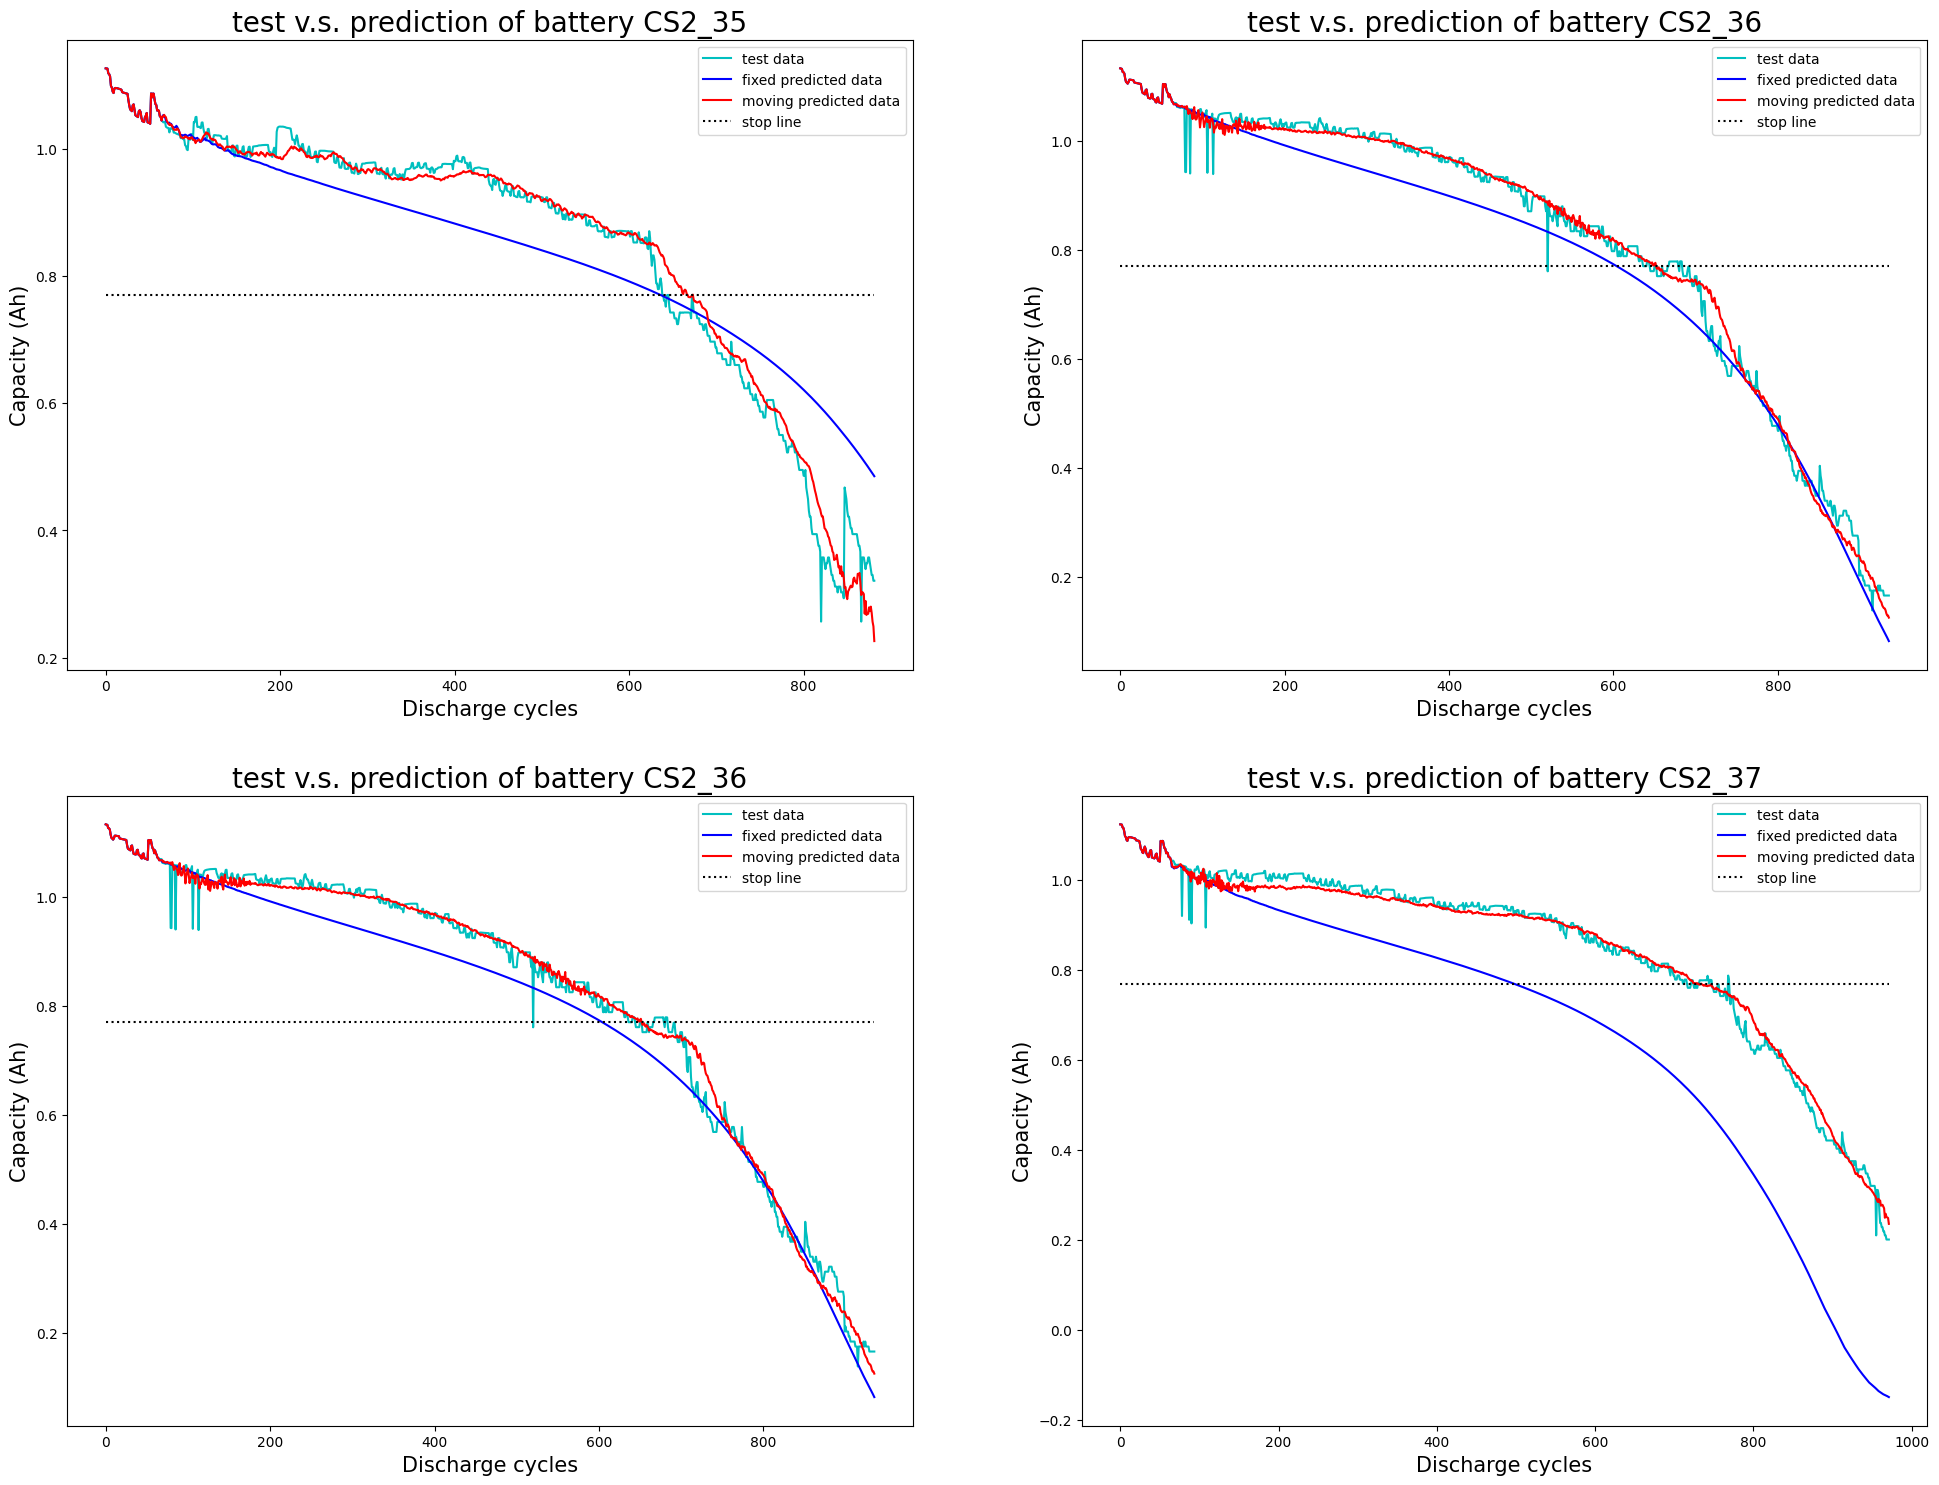

In [ ]:
fig,ax = plt.subplots(2, 2, figsize=(24, 18))

for i in range(2):
    for j in range(2):
        t = i + j
        battery_name = Battery_list[t]
        test_data = Battery[battery_name]['capacity']
        fixed_predict_data = fixed_result_list[t]
        moving_predict_data = moving_result_list[t]
        x = [t for t in range(len(test_data))]
        threshold = [Rated_Capacity*0.7] * len(test_data)
        ax[i][j].plot(x, test_data, 'c', label='test data')
        ax[i][j].plot(x, fixed_predict_data, 'b', label='fixed predicted data')
        ax[i][j].plot(x, moving_predict_data, 'r', label='moving predicted data')
        ax[i][j].plot(x, threshold, 'black', ls=':', label='stop line')
        ax[i][j].legend()
        ax[i][j].set_xlabel('Discharge cycles', fontsize=15)
        ax[i][j].set_ylabel('Capacity (Ah)', fontsize=15)
        ax[i][j].set_title('test v.s. prediction of battery ' + battery_name, fontsize=20)
plt.show()

# 3. use grid-search to determ parameters

In [ ]:
Rated_Capacity = 1.1
feature_size = 64
feature_num = 1
dropout = 0.0
epochs = 500
nhead = 1
alpha = 0.1

weight_decay = 0.0
noise_level = 0.0
metric = 're'

states = {}
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
for K in tqdm([4, 8, 16, 32], position=0):
    for lr in tqdm([0.0001, 0.001, 0.01], position=1):
        for num_layers in tqdm([1, 2, 3], position=2):
            for hidden_dim in [8, 16, 32, 64]:
                show_str = 'K={}, lr={}, num_layers={}, hidden_dim={}'.format(K, lr, num_layers, hidden_dim)
                print(show_str)
                SCORE = []
                for seed in range(5):
                    print('seed:{}'.format(seed))
                    score_list, _, _ = train(lr=lr, feature_size=feature_size, feature_num=feature_num, hidden_dim=hidden_dim,
                                             num_layers=num_layers, nhead=nhead, weight_decay=weight_decay, epochs=epochs, seed=seed,
                                             dropout=dropout, alpha=alpha, noise_level=noise_level, metric=metric, device=device)
                    print(np.array(score_list))
                    print(metric + ': {:<6.4f}'.format(np.mean(np.array(score_list))))
                    print('------------------------------------------------------------------')
                    for s in score_list:
                        SCORE.append(s)

                print(metric + ' mean: {:<6.4f}'.format(np.mean(np.array(SCORE))))
                states[show_str] = np.mean(np.array(SCORE))
                print('===================================================================')

min_key = min(states, key = states.get)
print('optimal parameters: {}, result: {}'.format(min_key, states[min_key]))

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

K=4, lr=0.0001, num_layers=1, hidden_dim=8
seed:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[0.33449477]
 [1.        ]
 [0.19384615]
 [0.48480463]]
re: 0.5033
------------------------------------------------------------------
seed:1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[0.09581882]
 [0.12607945]
 [1.        ]
 [0.16353111]]
re: 0.3464
------------------------------------------------------------------
seed:2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[0.03832753]
 [0.91364421]
 [0.13076923]
 [1.        ]]
re: 0.5207
------------------------------------------------------------------
seed:3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[0.10278746]
 [1.        ]
 [0.56153846]
 [0.14037627]]
re: 0.4512
------------------------------------------------------------------
seed:4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.        ]
 [0.09671848]
 [0.14923077]
 [0.16353111]]
re: 0.3524
------------------------------------------------------------------
re mean: 0.4348
K=4, lr=0.0001, num_layers=1, hidden_dim=16
seed:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.        ]
 [0.76165803]
 [0.14307692]
 [0.09406657]]
re: 0.4997
------------------------------------------------------------------
seed:2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.        ]
 [0.81519862]
 [0.35076923]
 [1.        ]]
re: 0.7915
------------------------------------------------------------------
seed:3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.        ]
 [0.22970639]
 [0.06      ]
 [0.40376266]]
re: 0.4234
------------------------------------------------------------------
seed:4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[0.02439024]
 [1.        ]
 [0.53538462]
 [1.        ]]
re: 0.6399
------------------------------------------------------------------
re mean: 0.6709
K=4, lr=0.0001, num_layers=1, hidden_dim=32
seed:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[0.04006969]
 [0.70811744]
 [0.01384615]
 [1.        ]]
re: 0.4405
------------------------------------------------------------------
seed:1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[0.09756098]
 [0.06217617]
 [0.28615385]
 [0.25325615]]
re: 0.1748
------------------------------------------------------------------
seed:2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.  ]
 [1.  ]
 [0.06]
 [1.  ]]
re: 0.7650
------------------------------------------------------------------
seed:3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.        ]
 [1.        ]
 [0.22923077]
 [0.28075253]]
re: 0.6275
------------------------------------------------------------------
seed:4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
re mean: 0.6016
K=4, lr=0.0001, num_layers=1, hidden_dim=64
seed:0


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[0.27351916]
 [1.        ]
 [1.        ]
 [1.        ]]
re: 0.8184
------------------------------------------------------------------
seed:1


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[0.10452962]
 [1.        ]
 [0.41846154]
 [1.        ]]
re: 0.6307
------------------------------------------------------------------
seed:2


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.        ]
 [0.31433506]
 [0.22      ]
 [1.        ]]
re: 0.6336
------------------------------------------------------------------
seed:3


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
/usr/local/lib/p

[[1.]
 [1.]
 [1.]
 [1.]]
re: 1.0000
------------------------------------------------------------------
seed:4


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:306: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.self_attn.num_heads is odd
  warnings.warn(f"enable_nested_tensor is True, but self.use_nested_tensor is False because {why_not_sparsity_fast_path}")
